# Statistical Inference.

**Descriptive statistics** describe a sample, **inferential statistics** infer predictions about a population.

**Statistical inference** deals with understanding the quality of parameter estimates of a sample.

Statistical inference produces **statistical propositions** about:

+ point estimates (a particular value that best approximates some parameter of interest),
+ confidence intervals (or set estimate) or
+ the rejection of a hypothesis.

Statistical inference is based on assumptions related to a statistical model or sampling process. Correct inference requires these assumptions to be correct.

In this session we will develop the **frequentist inference paradigm**. It bases the production of propositions by considering repeated sampling of a population.**P-values and confidence intervals are its most common propositions**.

# Index

### 1 Variability in estimates.
* 1.1 Point estimates
* 1.2 Sample mean distribution
* 1.3 Standard Error
* 1.4 Bootstraping
* 1.5 Confidence Intervals

### 2 Hypothesis testing
* 2.1. Confidence Interval tests
* 2.2. P-values
* 2.3. t-test
* 2.4. Chi-squared test
* 2.5. Wilcoxon signed-rank test



### Reminder

After exploring the data and computing some descriptive statistics from the National Survey of Family Growth (NSFG) we have seen some **apparent effects** that seem to support a hypothesis: The mean pregnant lenght for first babies is larger than for other babies.

But there are still **important** questions to be solved:

+ What is the probability that **a result is caused by chance** (due to the particular sample)?
+ Is it **statistically significant**?
+ Is it **relevant**?

In [3]:
file = open('files/2002FemPreg.dat', 'r')

def chr_int(a):
    if a == '  ' or a == '':
        return 0
    else:
        return int(a)

preg=[]
for line in file:
    lst  = [int(line[:12]), int(line[274:276]), int(line[276]), \
                 chr_int(line[277:279]), float(line[422:440])]
    preg.append(lst)


import pandas as pd
df = pd.DataFrame(preg)
df.columns = ['caseid', 'prglength', 'outcome', 'birthord', 'finalwgt']
firstbirth = df[(df.outcome == 1) & (df.birthord == 1)]
othersbirth = df[(df.outcome == 1) & (df.birthord >= 2)]

# descriptive statistics
muf = firstbirth['prglength'].mean()
stdf = firstbirth['prglength'].std()

print('First babies mean:',muf, 'STD:',stdf)

First babies mean: 38.60095173351461 STD: 2.7919014146687204


In [21]:
firstbirth.shape

(4413, 5)

In [23]:
df.shape

(4413,)

In [24]:
othersbirth.shape

(4735, 5)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
muo = othersbirth['prglength'].mean()
stdo = othersbirth['prglength'].std()
print('Other babies mean:', muo, 'STD:',stdo)

Other babies mean: 38.52291446673706 STD: 2.6158523504392375


## 1. Variability in estimates.

Descriptive statistics are not equal to the *truth* but they are better as more data become available.

Moreover, they vary from one sample to another. It would be useful to know how variable they are from one sample to another!

### 1.1. Point estimates

Let's suppose that we want to estimate the *population mean* based on the sample.

The most intuitive
way to go about doing this is to simply take the *sample mean*. The sample mean is a **point estimate of the population mean**. If we can only choose one value to estimate the population mean, this is our best guess.

We can generate point estimates of other population parameters, such as the *population median* or *population standard deviation*.

Estimates generally vary from one sample to another, and this sampling variation suggests our estimate may be close, but it will not be exactly equal to the parameter.
We can see this by plotting a **running mean** from our data.

In [6]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np

running_mean = np.array([0.0] * (len(firstbirth['prglength'])+1)) #array of zero's
running_mean[0] = firstbirth['prglength'].values[0]

i = 1
for x in firstbirth['prglength']:
    running_mean[i] = running_mean[i-1] + x
    i += 1

running_mean = running_mean / np.array(range(1,len(firstbirth['prglength'])+2))

mean = running_mean[-1]

print(mean)

38.60104213864975


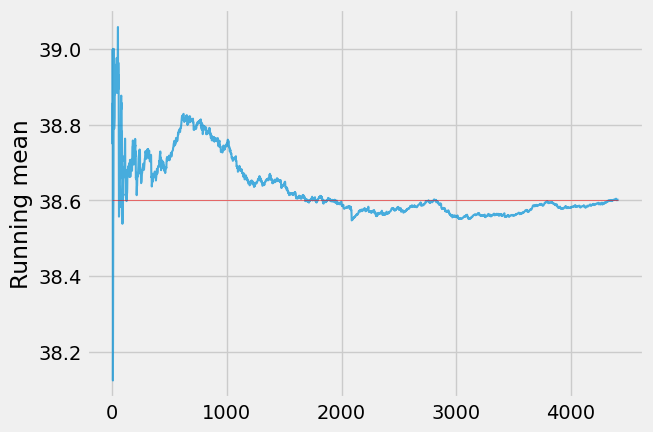

In [7]:
with plt.style.context('fivethirtyeight'):
    plt.plot(running_mean, lw=1.5, alpha=0.7)
    plt.ylabel('Running mean')
    plt.plot([0, len(firstbirth['prglength'])-1], [mean, mean], 'r-', lw=0.5, alpha=0.7)

plt.show()

It is important to note that even after 1000 samples, the mean can substantially vary. So, if we get several samples from a population we can build the *estimate distribution*.

### 1.2. Sample mean distribution

In our case, if we consider the full dataset a population, we can build the **empirical distribution of the sample mean** for a given number of observations (f.e. samples with 1000 observations).

In [8]:
df_aux = firstbirth['prglength']     # population

N_test = 10000                   # number of different samples from the population
elements = 1000                  # number of observations in each sample
means = [0] * N_test             # samples' mean array

for i in range(N_test):          # sample generation
    rows = np.random.choice(df_aux.index.values, elements)
    sampled_df = df_aux.loc[rows]
    means[i]=sampled_df.mean()

In [11]:
len(means)

10000

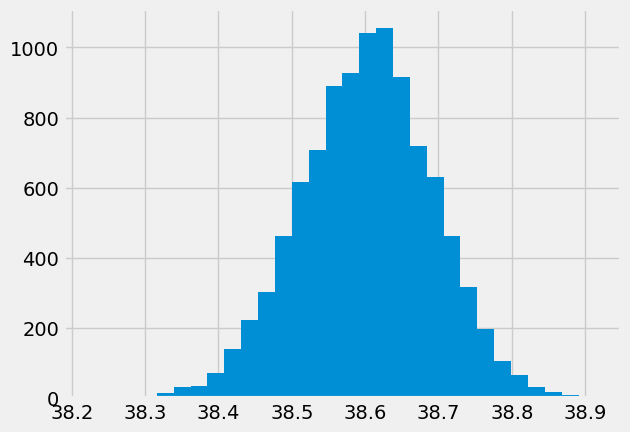

In [9]:
with plt.style.context('fivethirtyeight'):
    plt.hist(means,bins=30)

plt.show()

We can use this empirical distribution to give sound answers to a series of interesting questions:

+ What is the uncertainty of the sample mean?
+ What is the probability of getting a sample mean $\geq$ than $x$? Or in other words, is a given sample mean probable?
+ Etc.

That is, we can produce statistical propositions!

<div class = "alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;"> The <b>sampling distribution</b> represents the distribution of a point estimate based on samples of a <b>fixed size</b> from a certain population.

It is useful to think of a particular point estimate as being drawn from such a distribution. Understanding the concept of a sampling distribution is central to understanding statistical inference.
</div>   

### 1.3. Standard error of the mean

If we do not have access to the population, the sampling distribution cannot be built empirically.

It can be mathematically shown that given $n$ independent observations $\{ x_i \}_{i=1,..,n}$ from a population with a standard deviation $\sigma_x$, the standard deviation of the sample mean $\sigma_{\bar{x}}$, or **standard error** is:

$$ SE = \frac{\sigma_{x}}{\sqrt{n}} $$

This allows **to estimate the standard deviation of the sample mean** if we don't perform the simulation process (f.e. because we have no access to the population).

Usually, $\sigma_x$ is not known and is substituted by its empirical estimate (that is sufficiently good if $n>30$ and the population distribution is not skewed).

In [12]:
# EXERCISE: Compute the standard error in 1000 samples of a Gaussian with mean = 0 and std = 1, in 3 different ways:

x = np.random.normal(0,1,1000)

# 1) Using the formula (this asumes we know the standard deviation)
SE1 = 1/np.sqrt(1000)

# 2) Using the formula but an estimation for the standard deviation from the whole
SE2 = np.std(x)/np.sqrt(1000)

# 3) By running several trials (as in 1.2)

N_test = 10000                   # number of different samples from the population
elements = 1000                  # number of observations in each sample
means = [0] * N_test             # samples' mean array

for i in range(N_test):          # sample generation
    x_aux = np.random.normal(0,1,1000)
    means[i]=np.mean(x_aux)

SE3 = np.std(means)

######

print('S1: ',SE1)
print('S2: ',SE2)
print('S3: ',SE3)


S1:  0.03162277660168379
S2:  0.03210417848176402
S3:  0.03163484407889964


(array([ 1.,  0.,  1.,  3.,  7., 11., 13., 16., 20., 26., 42., 34., 46.,
        52., 66., 76., 92., 77., 75., 63., 58., 53., 44., 45., 24., 18.,
         9., 10., 10.,  3.,  5.]),
 array([-3.26109295, -3.06623346, -2.87137396, -2.67651447, -2.48165498,
        -2.28679549, -2.091936  , -1.89707651, -1.70221702, -1.50735753,
        -1.31249803, -1.11763854, -0.92277905, -0.72791956, -0.53306007,
        -0.33820058, -0.14334109,  0.05151841,  0.2463779 ,  0.44123739,
         0.63609688,  0.83095637,  1.02581586,  1.22067535,  1.41553484,
         1.61039434,  1.80525383,  2.00011332,  2.19497281,  2.3898323 ,
         2.58469179,  2.77955128]),
 <BarContainer object of 31 artists>)

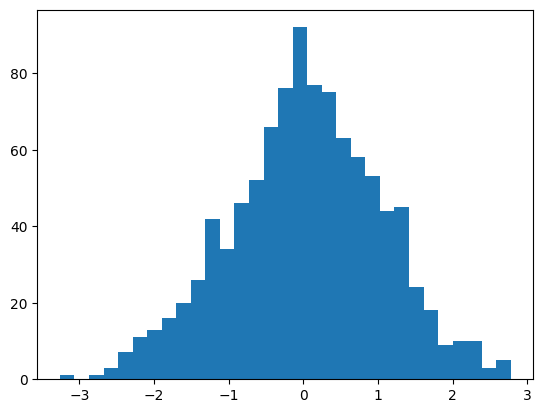

In [13]:
plt.hist(x,31)

(array([  3.,   7.,  14.,  26.,  42.,  68., 126., 197., 281., 380., 526.,
        592., 745., 871., 878., 895., 865., 805., 680., 579., 455., 337.,
        228., 172., 104.,  56.,  38.,  17.,   8.,   2.,   3.]),
 array([-0.11080299, -0.10356754, -0.09633208, -0.08909662, -0.08186116,
        -0.0746257 , -0.06739024, -0.06015479, -0.05291933, -0.04568387,
        -0.03844841, -0.03121295, -0.02397749, -0.01674204, -0.00950658,
        -0.00227112,  0.00496434,  0.0121998 ,  0.01943526,  0.02667071,
         0.03390617,  0.04114163,  0.04837709,  0.05561255,  0.06284801,
         0.07008347,  0.07731892,  0.08455438,  0.09178984,  0.0990253 ,
         0.10626076,  0.11349622]),
 <BarContainer object of 31 artists>)

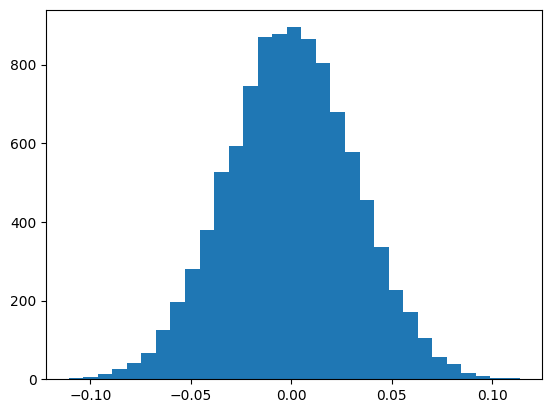

In [14]:
plt.hist(means,31)

Note the **standard error of the difference of two sample means** can be constructed from the
standard errors of the separate sample means, as follows:

$$ SE_{\bar{x}_1 - \bar{x}_2 } = \sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}} $$

Let's calculate the standard error of the difference between the pregnancy length of first babies and other babies:

In [16]:
m= len(firstbirth['prglength'])
n= len(othersbirth['prglength'])

SE = np.sqrt( ((firstbirth['prglength'].std()**2)/(m)) + \
                ((othersbirth['prglength'].std()**2)/(n)) )
print(SE)

0.05666953041905679


In real problems we do not have access to the population and the SE is calculated using empirical estimates.

In [18]:
N = 300 #the higher the N the closest our empirical estimate to the real one
rows = np.random.choice(firstbirth.index.values, N)
sampled_firstbirth = firstbirth.loc[rows]

rowso = np.random.choice(othersbirth.index.values, N)
sampled_othersbirth = othersbirth.loc[rowso]

SE = np.sqrt( ((sampled_firstbirth['prglength'].std()**2)/(N)) + \
                ((sampled_othersbirth['prglength'].std()**2)/(N)) )
print(SE)

0.25716214175060537


### 1.4. Bootstraping

Bootstrapping is a statistical procedure that resamples a single dataset to create many simulated samples.
It allows assigning measures of accuracy (defined in terms of bias, variance, etc.) to sample estimates (mean, median, SE, etc).

The simplest bootstrap method involves taking an original data set of $N$ values, and sampling from it to form a new sample (called a 'resample' or bootstrap sample) that is also of size $N$. The bootstrap sample is taken from the original using **sampling with replacement** (a population element can be selected more than one time).

This process is repeated a large number of times (typically 1,000 or 10,000 times), and for each of these bootstrap samples we compute the desired estimate (each of these are called bootstrap estimates). We now have a histogram of bootstrap estimates. This provides an estimate of the shape of the distribution of the mean from which we can answer questions about how much the mean varies.

If the dataset is enormous and computational efficiency is an issue,
smaller samples can be used to bootstrap, such as 50% or 80% of the size of the dataset. Check the impact in the following example:


In [20]:
df.shape

(4413,)

38.60121312032631 0.042437409768881135


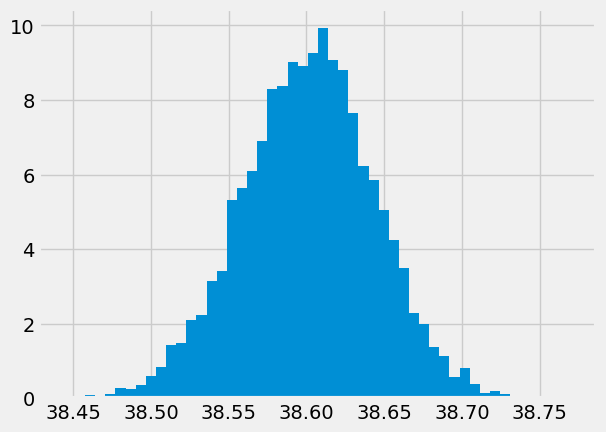

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

xbar = [0]*10000 #variable to save the means on each bootstrap sample
X = np.array(firstbirth['prglength'])
elements = 4413  # we take bootstrap samples of 100 elements out of 4413

for i in range(10000):
    sample = [X[a] for a in np.random.randint(len(X), size=elements)] # Return 100 integers (indices) bt 0 and 4413
    xbar[i] = np.mean(sample)

print(np.mean(xbar), np.std(xbar))
with plt.style.context('fivethirtyeight'):
    plt.hist(xbar, bins=50, density=True)

0.07832039428959887 0.05773628398913347


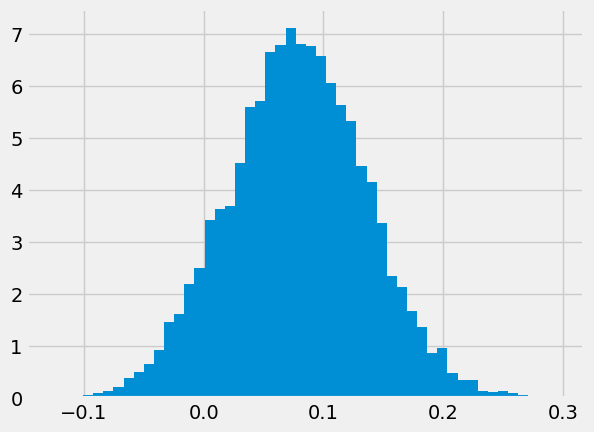

In [35]:
# EXERCISE: Apply bootstrap to estimate the standard error of the difference of the two sample means

xbar = [0]*10000
xbar1 = [0]*10000
xbar2 = [0]*10000

X1 = np.array(firstbirth['prglength'])
X2 = np.array(othersbirth['prglength'])

elements = 4413  # we take bootstrap samples of 100 elements out of 4413

for i in range(10000):

    sample1 = [X1[_] for _ in np.random.randint(len(X1), size=elements)] # Return 100 integers (indices) bt 0 and 4413
    xbar1[i] = np.mean(sample1)

    sample2 = [X2[_] for _ in np.random.randint(len(X2), size=elements)] # Return 100 integers (indices) bt 0 and 4413
    xbar2[i] = np.mean(sample2)

    xbar[i] = xbar1[i]-xbar2[i]

print(np.mean(xbar), np.std(xbar))

with plt.style.context('fivethirtyeight'):
    plt.hist(xbar, bins=50, density=True)


0.08291123951960111 0.05092434596414011


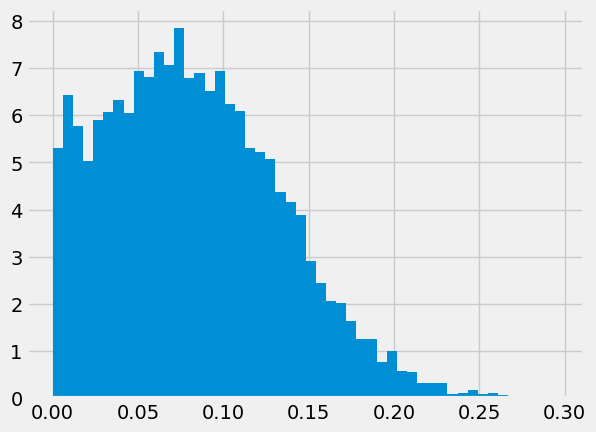

In [37]:

print(np.mean(np.abs(xbar)), np.std(np.abs(xbar)))

with plt.style.context('fivethirtyeight'):
    plt.hist(np.abs(xbar), bins=50, density=True)

In [38]:
SE = np.sqrt( ((firstbirth['prglength'].std()**2)/(m)) + \
                ((othersbirth['prglength'].std()**2)/(n)) )
print(SE)

0.05666953041905679


### Exercise

Let's consider a dataset of accidents in Barcelona in 2019. This dataset can be download from OpenDataBCN website (http://opendata.bcn.cat/), Barcelona's City Hall open data service. Each register in the dataset represents an accident by a series of features: weekday, hour, address, number of dead and injured people, etc. This dataset will represent our population: the set of all reported traffic accidents in Barcelona during 2019.
In https://dieguico.cartodb.com/viz/50b06d8c-13ab-11e5-8619-0e4fddd5de28/public_map you can visualize a map of accidents in the city of Barcelona by hour of day, and by day of week.

In [ ]:
import matplotlib.pylab as plt
from matplotlib import cm
import math
import pandas as pd
import numpy as np
import random

%matplotlib inline
plt.style.use('seaborn-whitegrid')
#plt.rc('text', usetex=True)
#plt.rc('font', family='times')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('font', size=12)

#data = pd.read_csv("files/2019_accidents_tipus_gu_bcn_.csv",encoding='latin-1')
data = pd.read_csv("files/2019_accidents_tipus_gu_bcn_.csv",encoding='utf-8')
print(data.columns)
#data.head()

Index(['Numero_expedient', 'Codi_districte', 'Nom_districte', 'Codi_barri',
       'Nom_barri', 'Codi_carrer', 'Nom_carrer', 'Num_postal_caption',
       'Descripcio_dia_setmana', 'Dia_setmana', 'Descripcio_tipus_dia',
       'NK_Any', 'Mes_any', 'Nom_mes', 'Dia_mes', 'Hora_dia',
       'Descripcio_torn', 'Descripcio_tipus_accident', 'Coordenada_UTM_X',
       'Coordenada_UTM_Y', 'Longitud', 'Latitud'],
      dtype='object')


We will create a new data column which is the date and a list with the number of accidents for every day of the year:

In [ ]:
#Create a new column which is the date x : str(x))
data['Date'] = '2019-'+data['Mes_any'].apply(lambda x : str(x)) + '-' +  data['Dia_mes'].apply(lambda x : str(x))
data['Date'] = pd.to_datetime(data['Date'])
accidents = data.groupby(['Date']).size()
print("Mean:", accidents.mean())

Mean: 28.865753424657534


Let's suppose that we are interested in describing the number of daily traffic accidents (accident rate) in the streets of Barcelona during 2019. In order to get a first idea of the data, we can plot the number of accidents for each day of 2019:

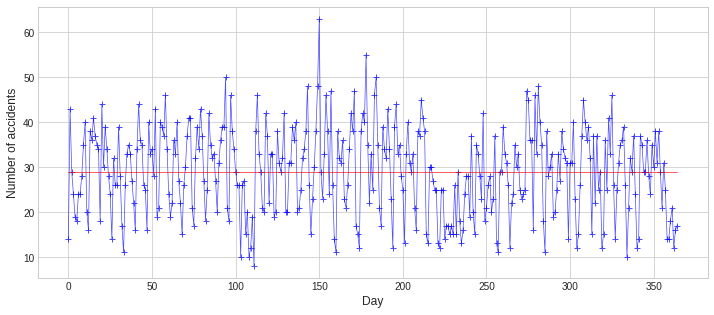

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.ylabel('Number of accidents')
plt.xlabel('Day')
plt.plot(range(0, 365), np.array(accidents), 'b-+', lw=0.7, alpha=0.7)
plt.plot(range(0, 365), [accidents.mean()]*365, 'r-', lw=0.7, alpha=0.9)
plt.show()

We can also plot the distribution of our variable of interest: the daily number of accidents.

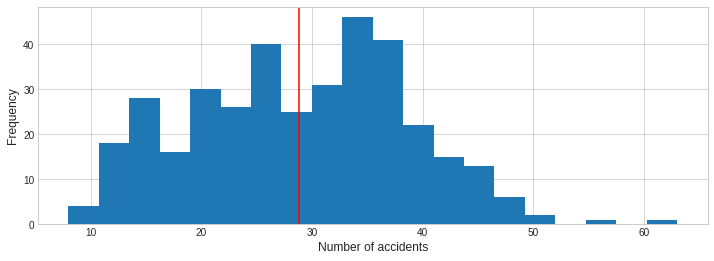

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.ylabel('Frequency')
plt.xlabel('Number of accidents')
plt.hist(np.array(accidents), bins=20)
ax.axvline(x=accidents.mean(), ymin=0, ymax=40, color=[1, 0, 0])
plt.savefig("bootmean.png",dpi=300, bbox_inches='tight')
plt.show()

If we have access to the whole *population*, the computation of the **accident rate** in 2019 is a simple operation: the total number of accidents divided by 365.

In [ ]:
print("Mean:", accidents.mean())

Mean: 28.865753424657534


But let's suppose that we have only access to a limited part of the data
(the *sample*): the number of accidents during *some days* of 2019 (let's say 200 days).

In [ ]:
df = accidents.to_frame()
rows = np.random.choice(df.index.values, 200)
sampled_df = df.loc[rows]

+ Compute an approximation of the population mean by using a point estimator of the mean and its standard deviation?

In [ ]:
# Your solution here

+ Use the bootstrapping method for estimating the mean and its estandard deviation.

In [ ]:
# Your solution here

### 1.5. Confidence intervals.



A point estimate provides a *single plausible value for a parameter*. However, a point
estimate is rarely perfect; usually there is some error in the estimate.

Instead of supplying
just a point estimate of a parameter, a next logical step would be to provide *a plausible
range of values* for the parameter.

A plausible range of values for the population parameter is called a **confidence interval**.

Our point estimate is the most plausible value of the parameter, so it makes sense to build
the confidence interval around the point estimate.

If a point estimate distribution is normal, its standard error SE represents the standard deviation associated with the estimate, and we know that roughly 95% of the time the estimate will be within 1.96 standard errors of the parameter.

#### Naive interpretation of the confidence interval

If the interval spreads out 1.96 standard errors from a normally distributed point estimate, intuitively we can say that we are **roughly 95% confident that we have captured the true parameter** (*this is not formally true, see later*).

$$ CI = [\mbox{point estimate} - 1.96 \times SE, \mbox{point estimate} + 1.96 \times SE] $$

**But what does “95% confident” mean?**

<div class = "alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
Suppose we took many (infinite) samples and built a confidence
interval from each sample. Then about 95% of those intervals
would contain the actual parameter.
</div>   

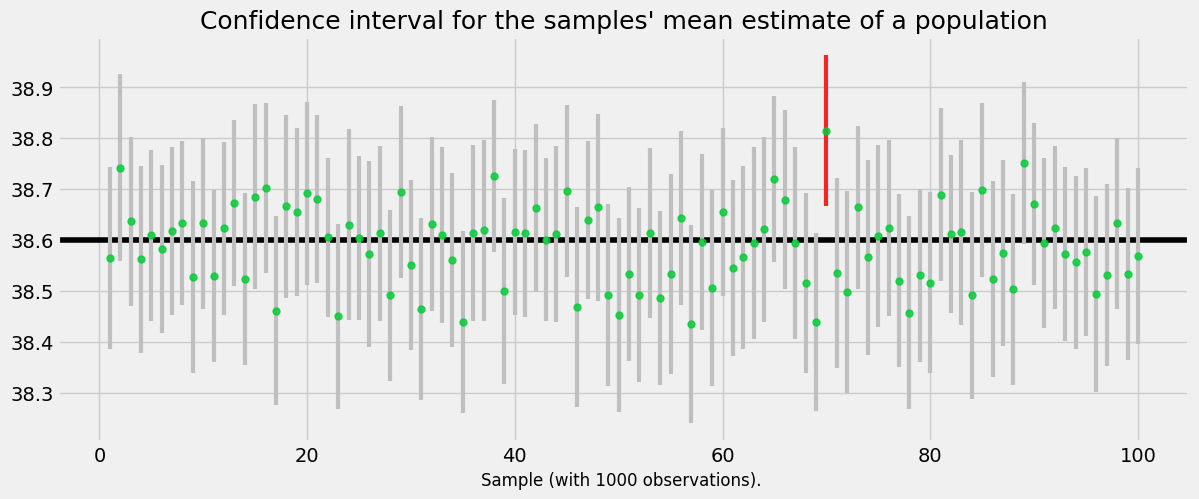

In [40]:
df = firstbirth['prglength']

n = 1000                                              # number of observations
N_test = 100                                          # number of samples with n observations
means = np.array([0.0] * N_test)                      # samples' mean
s = np.array([0.0] * N_test)                          # samples' std
ci = np.array([[0.0,0.0]] * N_test)
tm = df.mean()                                        # "true" mean

for i in range(N_test):                               # sample generation and CI computation
    rows = np.random.choice(df.index.values, n)
    sampled_df = df.loc[rows]
    means[i]=sampled_df.mean()
    s[i]=sampled_df.std()
    ci[i] = means[i] + np.array([-s[i]*1.96/np.sqrt(n), s[i]*1.96/np.sqrt(n)])

out1 = ci[:,0] > tm                                   # CI that do not contain the "true" mean
out2 = ci[:,1] < tm

with plt.style.context('fivethirtyeight'):            # plot of the CI distribution
    fig, ax = plt.subplots(1, 1, figsize=(13, 5))
    ind = np.arange(1, N_test+1)
    ax.axhline(y=tm, xmin=0, xmax=N_test+1, color=[0, 0, 0])
    ci = np.transpose(ci)
    ax.plot([ind,ind], ci, color='0.75', marker='_', ms=0, linewidth=3)
    ax.plot([ind[out1], ind[out1]], ci[:, out1], color=[1, 0, 0, 0.8], marker='_', ms=0, linewidth=3)
    ax.plot([ind[out2], ind[out2]], ci[:, out2], color=[1, 0, 0, 0.8], marker='_', ms=0, linewidth=3)
    ax.plot(ind, means, color=[0, .8, .2, .8], marker='.', ms=10, linestyle='')
    ax.set_title("Confidence interval for the samples' mean estimate of a population",
             fontsize=18)
    ax.set_xlabel('Sample (with %d observations). '  %n, fontsize=12)
plt.show()

#### Observation

Our reasoning is based on an important result from probability theory that can be directly applied to our problem: the Central Limit Theorem. **We assume the distribution of our sample is well approximated by a normal model**.

Suppose we want to consider confidence intervals where the confidence level is somewhat
higher than 95%: perhaps we would like a confidence level of 99% or of 99.9%. In general, if the point estimate follows the normal model with standard error SE, then a
confidence interval for the population parameter is

$$ \mbox{point estimate} \pm z \times SE_x $$

where $z$ corresponds to the confidence level selected:

| Confidence Level  | z Value  |
|---|---|
|  90% | 1.65 |
|  95% | 1.96 |
|  99% | 2.58 |
|  99,9% | 3.291 |

#### Interpreting confidence intervals

The correct interpretation of a confidence interval is:

> In 95% of the cases, when I compute the confidence interval from a sample, the true mean of the population will fall within $\pm 1.96 \times SE_x$. 5% of the cases, it will not.

Because the true parameter (population mean) is an unknown value, we don’t know if we are in the 5% or the 95%. BUT 95% is pretty good so we say something like “we are 95% confident that we have captured the true parameter". This is a common shorthand for the idea that the calculations “work” 95% of the time.

Remember that we can’t have a 100% confidence interval. By definition, the population mean is not known.


## 2. Hypothesis testing

Let's take our initial question: **Were the observed effects related to the birth pregnancy length of first babies real or not?**

Technically,  the question is usually translated to: **Were the observed effects statistically significant**?

The process of determining the **statistical significance** of an effect is called **hypothesis testing**.

This process starts by simplifying the options into two competing hypotheses:

+ $H_0$: The mean pregnancy length for first babies and for other babies is the same (there is only one population, one true mean, and ``first babies`` and ``other babies`` are just different samples from the same population).
+ $H_A$: The mean pregnancy length for ``first babies`` and for ``other babies`` is different (``first babies`` and ``other babies`` are two samples from two different populations).

We call $H_0$ the **null hypothesis** and it represents a *skeptical* point of view: the effect we have observed is due to chance (due to the specific sample bias).

$H_A$ is the **alternative hypothesis** and it represents the other point of view: the effect is real.

<div class = "alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;"> <b> Hypothesis Testing </b> <br>
The general rule of frequentist hypothesis testing is: we will not <b>accept</b> $H_A$ unless the observed effect is <b>implausible</b> under $H_0$.
</div>   

### 2.1. Testing hypotheses using confidence intervals.

We can use the concept represented by *confidence intervals* to measure the **plausability** of a hypothesis.

We can start the evaluation of the hypotheses setup by comparing first babies and other babies pregnancy length using a *point estimate from the first babies sample*: $ \bar{x}_{fb} = 38.6$.

This estimate suggests the average lenght is actually longer. However, to evaluate
whether this provides strong evidence that there is a difference, we must consider the
uncertainty associated with $ \bar{x}_{fb}$ (The difference between
$\bar{x}_{fb}$ and $ \bar{x}_{ob}$ could be due to sampling variation).

Based on our sample, the 95% confidence interval for the mean pregnancy length for first babies can be calculated as:

In [44]:
# 95%
df = firstbirth['prglength']
n = len(df)
mean=df.mean()
s=df.std()
ci = [mean - s*1.96/np.sqrt(n),  mean + s*1.96/np.sqrt(n)]
print('Mean:', mean, '| CI of the mean:',ci)

Mean: 38.60095173351461 | CI of the mean: [38.51857791730805, 38.683325549721175]


In [45]:
# 90%
df = firstbirth['prglength']
n = len(df)
mean=df.mean()
s=df.std()
ci = [mean - s*1.65/np.sqrt(n),  mean + s*1.65/np.sqrt(n)]
print('Mean:', mean, '| CI of the mean:',ci)

Mean: 38.60095173351461 | CI of the mean: [38.53160642905501, 38.670297037974215]


In [42]:
np.mean(othersbirth['prglength'])

38.52291446673706

Because the other babies' mean, 38.52, falls in the range of plausible values, we cannot say the null hypothesis is **implausible**.

That is, **we failed to reject the null hypothesis, $H_0$**.


### Interpreting CI tests.

Hypothesis testing is built around rejecting or failing to reject the null hypothesis.
That is, we do not reject $H_0$ unless we have strong evidence. But what precisely does strong
evidence mean? As a general rule of thumb, for those cases where the null hypothesis is
actually true, we do not want to incorrectly reject $H_0$ more than 5% of the time. This
corresponds to a **significance level** of $\alpha =0.05$.

> If we use a 95% confidence interval to test a hypothesis where the null hypothesis is
true, we will make an error whenever the point estimate is at least 1.96 standard errors
away from the population parameter. This happens about 5% of the time (2.5% in each
tail).

### Exercise

Apply the CI method to the mean rate of traffic accidents in Barcelona during 2018 and 2019 using a point estimate from the 2019 sample:

In [ ]:
# Your solution here

This estimate suggests that during 2019 the mean rate of
traffic accidents in Barcelona **was lower** than 2018. But is this effect statistically significant?

In [ ]:
# Your solution here

Because 2018 accident rate estimate falls in the range of plausible values of 2019, we say the difference in 2018 and 2019 daily accident rate is not statistically significant at a 95%.

### 2.2. Testing hypotheses using P-values.

The modern notion of **statistical significance** was developed by R.A.Fisher in the 1920's when looking for a test to decide whether variation in crop yields were due to some specific intervention or merely random factors beyond experimental control.

Fisher first assumed that fertilizer caused no difference (**null hypothesis**) and then calculated $P$ the probability that an observed yield in a fertilized field would occur if fertilizer had no real effect. This probability is called **p-value**.

<div class = "alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
The <b> P value </b>  is a measure of whether an observed result can be attributed to chance. It is obtained as the
the probability of obtaining results at least as extreme as the results actually observed when the null hypothesis of a study question is true.
</div>   

We typically use a summary statistic of the data, e.g. the sample mean, to help compute the p-value and evaluate the hypotheses. A very small p-value means that such an extreme observed outcome would be very unlikely under the null hypothesis:

> Usually, if $P$ is less than 0.05 means there is less than 5% chance your results happened by chance and the the result is declared **statistically significant**. This leads to two possible conclusions: **there is a real effect or the result is an improbable fluke**. Fisher's method offers no way to know which is which.

The goal of classical hypothesis testing is to answer the question, “*Given a sample and an apparent effect, what is the probability of seeing such an effect by chance?*”

Here’s how we answer that question:

+ The first step is to quantify the size of the apparent effect by choosing a test statistic. In the NSFG example, the apparent effect is a difference in pregnancy length between first babies and others, so a natural choice for the test statistic is the **difference in means between the two groups**.

+ The second step is to define a **null hypothesis**, which is a model of the system based on the assumption that the apparent effect is not real (skeptical point of view). In the NSFG example the null hypothesis is that there is no difference between first babies and others; that is, that pregnancy lengths for both groups have the same distribution.

+ The third step is to compute a **p-value**, which is the probability of seeing the apparent effect if the null hypothesis is true. In the NSFG example, we would compute the absolute difference in means, then compute the probability of seeing a difference as big, or bigger, under the null hypothesis.

+ The last step is to **interpret the result**. If the p-value is low, the effect is said to be **statistically significant**, which means that it is unlikely to have occurred by chance. In that case we infer that the effect is more likely to appear in the larger population.

A common error equates **statistical significance** to **practical importance/relevance**. When working with large datasets, we can detect statistical significance for small effects that are meaningless in practical terms. See https://en.wikipedia.org/wiki/Misuse_of_p-values

### Example

Suppose we toss a coin 250 times and see 140 heads and 110 tails. Based on this result, we might suspect that the coin is biased; that is, more likely to land heads. We can compute the p-value of this hypothesis by simulating samples of 250 tossings.

In [ ]:
import random
heads, tails = 140,110
test = abs(heads - tails)
n = heads + tails

N = 100000                 # number of samples
diff = []                  # list for storing the absolute values of the means' difference

for i in range(N):
    sample = [random.choice('HT') for _ in range(n)]      # sample generation
    h = sample.count('H')                                 # number of H
    t = sample.count('T')                                 # number of T
    diff.append(abs(h - t))                               # absolute value of the means' differences                         # absolute value of the means' differences

count = sum(1 for i in range(N) if diff[i] >= test)       # counting the number of differences
                                                          # that are more extreme than the observed
                                                          # effect
print('P is',float(count)/N)
if float(count)/N < 0.05:
    print('We cannot discard that the coin is biased.')
else:
    print('There is no evidence of bias')

P is 0.06529
There is no evidence of bias


<div class="alert alert-info">The most common approach to hypothesis testing is to choose a threshold value for deciding is the effect is likely or not. A common choice is 5% (p-value less than 0.05)</div>

### 2.3. t-test

We saw that the mean pregnancy length for first babies is slighly longer. Let's see if the difference in means is significant.

+ The null hypothesis is that the mean of the two groups is the same and the observed difference is due to chance.

+ To compute the p-values we can pool the distribution of all live births, generate random samples that are the same size as the observed samples, and compute the difference in means under the null hypothesis.

+ If we generate a large number of samples, we can count how often the difference in means (due to chance) is as big or bigger than the difference we actually observed. This fraction is the p-value.

This procedure is known as the **t-test** or student's t-test. Note it is a **parametric test**, i.e. it assumes that the data is normally distributed.



<div class = "alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;"> The <b>t-test</b> is a statistical hypothesis test for testing whether two samples are expected to have been drawn from the same population. The test works by checking the means from two samples to see if they are significantly different from each other.  </div>

For pregnancy length, we have the following data:

In [49]:
m= len(firstbirth['prglength'])
n= len(othersbirth['prglength'])
p = abs(firstbirth['prglength'].mean() - othersbirth['prglength'].mean())
print('m:',m, 'n:', n)
print('mean difference in weeks: ', p)

m: 4413 n: 4735
mean difference in weeks:  0.07803726677754952


To approximate the p-value, we can pool the distributions, generate samples with size $m$ and $n$ and compute the difference in the mean.

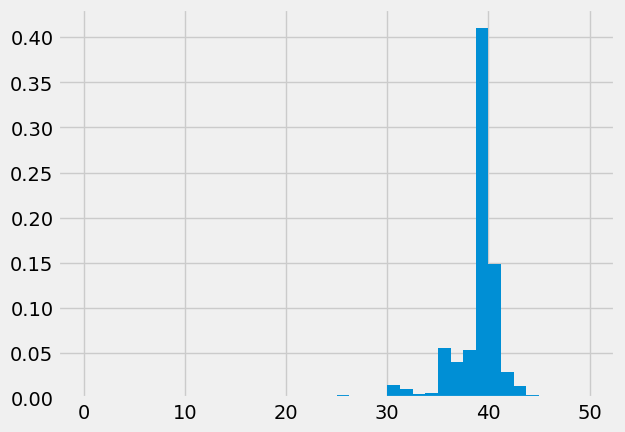

In [50]:
x = firstbirth['prglength']
y = othersbirth['prglength']
pool = np.concatenate([x,y])

with plt.style.context('fivethirtyeight'):    # plotting the pooled distribution
    plt.hist(pool, bins=40, density=True)

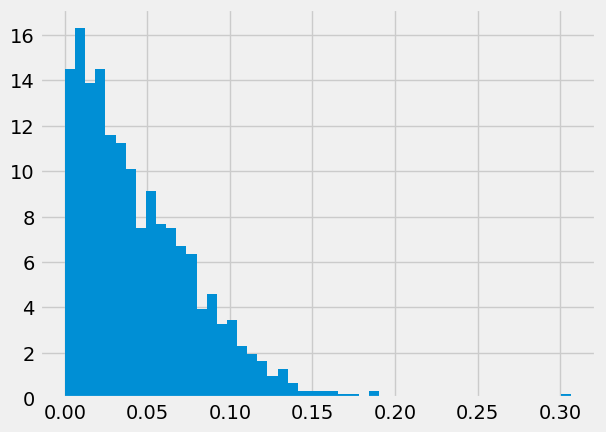

In [51]:
import random
N = 1000                                            # number of samples
diff = []
for i in range(N):
    p1 = [random.choice(pool) for _ in range(m)]
    p2 = [random.choice(pool) for _ in range(n)]
    diff.append(abs(np.mean(p1)-np.mean(p2)))

with plt.style.context('fivethirtyeight'):          # plotting difference values
    plt.hist(diff, bins=50, density=True)

In [ ]:
diff2 = np.array(diff)
w1 = np.where(diff2 > p)[0]      # counting how many differences are larger than the observed one

print('p-value (Simulation)=', len(w1)/float(N), '(', len(w1)/float(N)*100 ,'%)', 'Difference =', p)
if len(w1)/float(N)<0.05:
    print('The effect is likely')
else:
    print('The effect is not likely')

p-value (Simulation)= 0.177 ( 17.7 %) Difference = 0.07803726677754952
The effect is not likely


The most common approach to hypothesis testing is to choose a threshold value for deciding is the effect is likely or not. A common choice is 5% (p-value $< 0.05$).

So, the effect is not likely!

You can calculate the p-value by simulation (as above) or using the python function <code>scipy.stats.ttest_ind</code> https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [ ]:
# using python functions
from scipy.stats import ttest_ind

print('P-value original data (Python function):', \
      ttest_ind(firstbirth['prglength'], othersbirth['prglength'])[1])

P-value original data (Python function): 0.16755412639415004


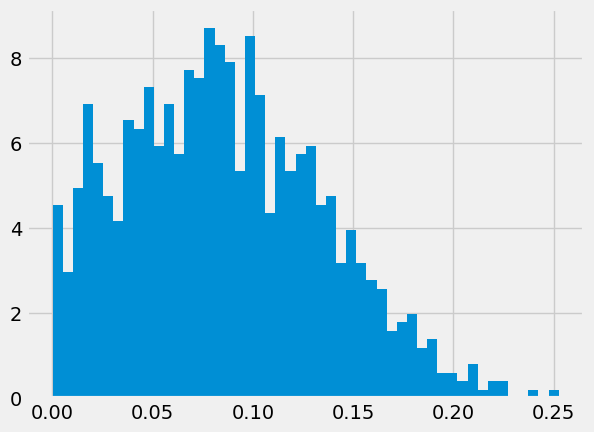

In [60]:
# No asumimos que x e y vienen de la misma distribución

import random
x = np.array(x)
y = np.array(y)
N = 1000                                            # number of samples
diff = []
for i in range(N):
    # sin reemplazo
    # p1 = [random.choice(x) for _ in range(m)]
    # p2 = [random.choice(y) for _ in range(n)]

    # con reemplazo
    p1 = [x[_] for _ in np.random.randint(len(x), size=len(x))] # Return 100 integers (indices) bt 0 and 4413
    p2 = [y[_] for _ in np.random.randint(len(y), size=len(y))] # Return 100 integers (indices) bt 0 and 4413

    diff.append(abs(np.mean(p1)-np.mean(p2)))

with plt.style.context('fivethirtyeight'):          # plotting difference values
    plt.hist(diff, bins=50, density=True)

In [61]:
diff2 = np.array(diff)
w1 = np.where(diff2 > p)[0]      # counting how many differences are larger than the observed one

print('p-value (Simulation)=', len(w1)/float(N), '(', len(w1)/float(N)*100 ,'%)', 'Difference =', p)
if len(w1)/float(N)<0.05:
    print('The effect is likely')
else:
    print('The effect is not likely')

p-value (Simulation)= 0.538 ( 53.800000000000004 %) Difference = 0.07803726677754952
The effect is not likely


### Exercise

Compute the p-value for the SNFG dataset free of outlier values. What is your opinion about this result? Is this effect **relevant**?

In [ ]:
import pandas as pd
df = pd.DataFrame(preg)
df.columns = ['caseid', 'prglength', 'outcome', 'birthord', 'finalwgt']

#data cleaning
df2 = df.drop(df.index[(df.outcome == 1) & (df['prglength'] > df['prglength'].median() + 6)])
df2[(df2.outcome == 1) & (df2['prglength'] > df2['prglength'].median() + 6)]
df3 = df2.drop(df2.index[(df2.outcome == 1) & (df2['prglength'] < df2['prglength'].median() - 10)])
df3[(df3.outcome == 1) & (df3['prglength'] < df3['prglength'].median() - 10)]

firstbirthc = df3[(df3.outcome == 1) & (df3.birthord == 1)]
othersbirthc = df3[(df3.outcome == 1) & (df3.birthord >= 2)]

m= len(firstbirthc['prglength'])
n= len(othersbirthc['prglength'])
p = abs(firstbirthc['prglength'].mean() - othersbirthc['prglength'].mean())
print('m:',m, 'n:', n)
print('mean difference in weeks: ', p)

m: 4351 n: 4681
mean difference in weeks:  0.10393095586685774


In [ ]:
# Your solution here

#### Paired or independent samples

The t-test can be formulated for independent samples <code>ttest_ind</code> and also for dependent (or paired) samples <code>ttest_rel</code>.

What are paired samples?
two data sets are "paired" when the following one-to-one relationship exists between values in the two data sets:
+ Each data set has the same number of data points.
+ Each data point in one data set is related to one, and only one, data point in the other data set.

Examples of paired samples in ML might be the same algorithm evaluated on different datasets or different algorithms evaluated on exactly the same training and test data.

#### Threshold of 5%

Note the choice of 5% is arbitrary, and the p-value depends on the choice of the test statistics and the model of the null hypothesis. So p-values should not be considered precise measurements.

p-values can be interpreted according to their order of magnitude: if the p-value is less than 1%, the effect is unlikely to be due to chance; if it is greater than 10%, the effect can plausibly be explained by chance. P-values between 1% and 10% should be considered borderline.

#### One-sided and two-sided tests.

We have defined the effect as *a difference in mean (positive or negative) as big or bigger than $\delta$*, **ignoring the sign**. A test like this is called **two-sided**.

If the relevant question is whether **pregnancy lengths are different for first babies**, then it makes sense to test the absolute difference in means, but if the hypothesis is that **first babies are likely to be late** we would not take the absolute value of the difference. This kind of test is called one-sided because it only counts one side of the distribution of differences.

To convert a two-sided test to one-sided text you can multiply the p-value by two and that's it!

### 2.4. Chi-squared test

We used the t-test to evaluate the significance of the difference in means between first babies and others.
BUT when we computed relative risk, we saw that ***first babies are more likely to
be early, less likely to be on time, and more likely to be late than other babies***.

We can test **hypothesis on ranked (categorical) data** using the **chi-squared test**.

<div class = "alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">The <b>Chi-Squared test</b> is a non-parametric statistical hypothesis test that assumes (the null hypothesis) that the observed frequencies for a <b>categorical variable</b> match the expected frequencies for the categorical variable. </div>

To calculate the chi-squared test by hand we proceed in five easy steps:

+ We define a set of categories, called cells, that each sample instance might fall
into. Following the babies example, there are six cells because there are two groups
(first babies and others) and three bins (early, on time or late).
(We can use the following definitions: a baby is early if it is born
during Week 37 or earlier, on time if it is born during Week 38, 39 or
40, and late if it is born duringWeek 41 or later.)

+ We compute the number of babies we expect in each cell. Under the
null hypothesis, we assume that the distributions are the same for the
two groups, so we can compute the pooled probabilities: $P(early)$,
$P(ontime)$ and $P(late)$. For first babies, we have $n$ = 4413 samples,
so under the null hypothesis
we expect $n \times P(early)$ first babies to be early, $n \times  P(ontime)$ to be
on time, etc. Likewise, we have $m$ = 4735 other babies, so we expect
$m \times  P(early)$ other babies to be early, etc.

+ For each cell we compute the deviation; that is, the difference between the observed value,
$O_i$, and the expected value, $E_i$.

+ We compute some measure of the **total deviation**; this quantity is called the test statistic. The most common choice here is the **chi-square statistic**:

$$ \chi^2 = \sum_i \frac{(O_i - E_i)^2}{E_i} $$

+ We can use simulation to compute the p-value, which is
the probability of seeing a chi-square statistic as high as the observed
value under the null hypothesis.

When the chi-square statistic is used, this process is called a **chi-square test**.
One feature of the chi-square test is that the distribution of the test statistic
can be computed analytically.


The Chi-square test and the p-value of the test can be obtained with the python function <code>scipy.stats.chisquare</code> https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html

In [ ]:
from scipy.stats import chisquare
a = chisquare([16, 18, 16, 14, 12, 12], [16, 16, 16, 16, 16, 16])
print('Chi-squared test statistic:', a[0], 'P-value of the test', a[1])

Chi-squared test statistic: 2.5 P-value of the test 0.7764950711233227


### Exercise

Using the data from the NSFG, compute the Chi-squared test statistic and its p-value. Use clean data (no outliers)

In [ ]:
# Your solution here

### 2.5. Wilcoxon Signed-Rank Test

The Wilcoxon signed rank test uses the sum of the signed ranks as the test statistic $𝑊$:
$$W=\sum_{i=1}^{N}[\text{sgn}(x_{2,i}-x_{1,i})*R_i]$$
where the i-th of N measurement pairs is indicated by ($x_{1,i},x_{2,i}$) and $R_i$ denotes the rank of the pair. The rank simply represents the position of an observation in an ordered list.

<div class = "alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">The <b>Wilcoxon signed-rank test</b> is a nonparametric statistical hypothesis test that compares two paired samples to assess whether their population mean ranks differ.</div>


The Wilcoxon signed-rank test and the p-value of the test can be obtained with the python function <code>scipy.stats.wilcoxon</code> https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html

Note that, by default (only one input), it is applied to differences between two sets of measurements

In [ ]:
from scipy.stats import wilcoxon
data1 = [0.873, 2.817, 0.121, -0.945, -0.055, -1.436, 0.360, -1.478, -1.637, -1.869]
data2 = [1.142, -0.432, -0.938, -0.729, -0.846, -0.157, 0.500, 1.183, -1.075, -0.169]
stat, p = wilcoxon(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=21.000, p=0.508
Probably the same distribution


<div class="alert alert-info"> In machine learning, non-parametric statistical tests are often used on samples of model skill scores in order to confirm that the difference in skill between models is significant</div>

### Frequentist general inference: Conclusions.

+ Point estimates are useful to build hypotheses.
+ We can measure the variability of the predicted estimate (PE) with standard error (SE) or 95% confidence intervals.
+ We measure the statistical significant of our hypothesis $H_A$ by formulating the null hipothesis ($H_0$) and computing $P(E|H_0)$ (setting a threshold $\alpha$ in advance, which is usually 0.05):
    + Accept $H_A$ if $P(E|H_0) < \alpha$.
    + Accept $H_0$ if $P(E|H_0) \geq \alpha$.
+ Non-parametric statistical hypothesis tests quantify the likelihood that two data samples have the same distribution

### The skeptic view

No matter how much data you have, you will still depend on intuition to decide how to interpret, explain and use the data.

Data can’t say anything. Data scientists are interpreters, offering one interpretation of what the useful narrative story derived from the data is (if there is one at all).

Cognitive Bias (f.e. confirmation bias, narrative bias) pollutes our view of data.

